<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-uis-student/raw/master/imgs/banner_dl.png" alt="Drawing" style="width:1700px;">

# <center> 13. **TEMPORAL SERIES ANALYSIS: FROM CLASSICAL TO RNN MODELS** </center>



## <span style="color:red"> Outline </span>
1. **Forecasting: Sequences and Time series**
2. **Forecasting from RNN models**
3. **Forecasting to predict stock market index**



In [ ]:
#@title 1. MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Machine_Learning_Course/')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/ia2


In [ ]:
#@title Load libraries { display-mode: "form" }
#@markdown Here is important to change to GPU

import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
print(tf.__version__)

2.14.0


#**1. Forecasting: Sequences and Time series**

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/applications.png" style="width:900;height:450px;">

Time series is everywere from signals thar represent monitoring industrial processes to series that track corporate business metrics. Other applications include economic, sales and Weather forescasting. So, time series are **ordered sequences**.


- In machine learning, a fundamental problem is **forecasting** over temporal series.

**1.1 Forecasting: preparing data**

To prepare data to acess over such models, we need to do a special configuration in data. In this case, training, validation and test sets are defined as follows:

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/setsplit.png" width="600" height="400">

**Remember**

In this regression problems, we define error as the different between forecast $f_t$ and actual value $y_t$, as: $error = f_t - y_t$. Typical metrics to measure this errors are:

- **the mean square error** ($mse = \frac{1}{N}\sum_{t=1}^{N}(f_t - y_t)^2$)
- **the  mean absolute error** ($mae = \frac{1}{N}\sum_{t=1}^{N}|f_t - y_t|$)


Now, we will try the proble to predict the temperature according to historical data in metereology.

**GO to the action!**








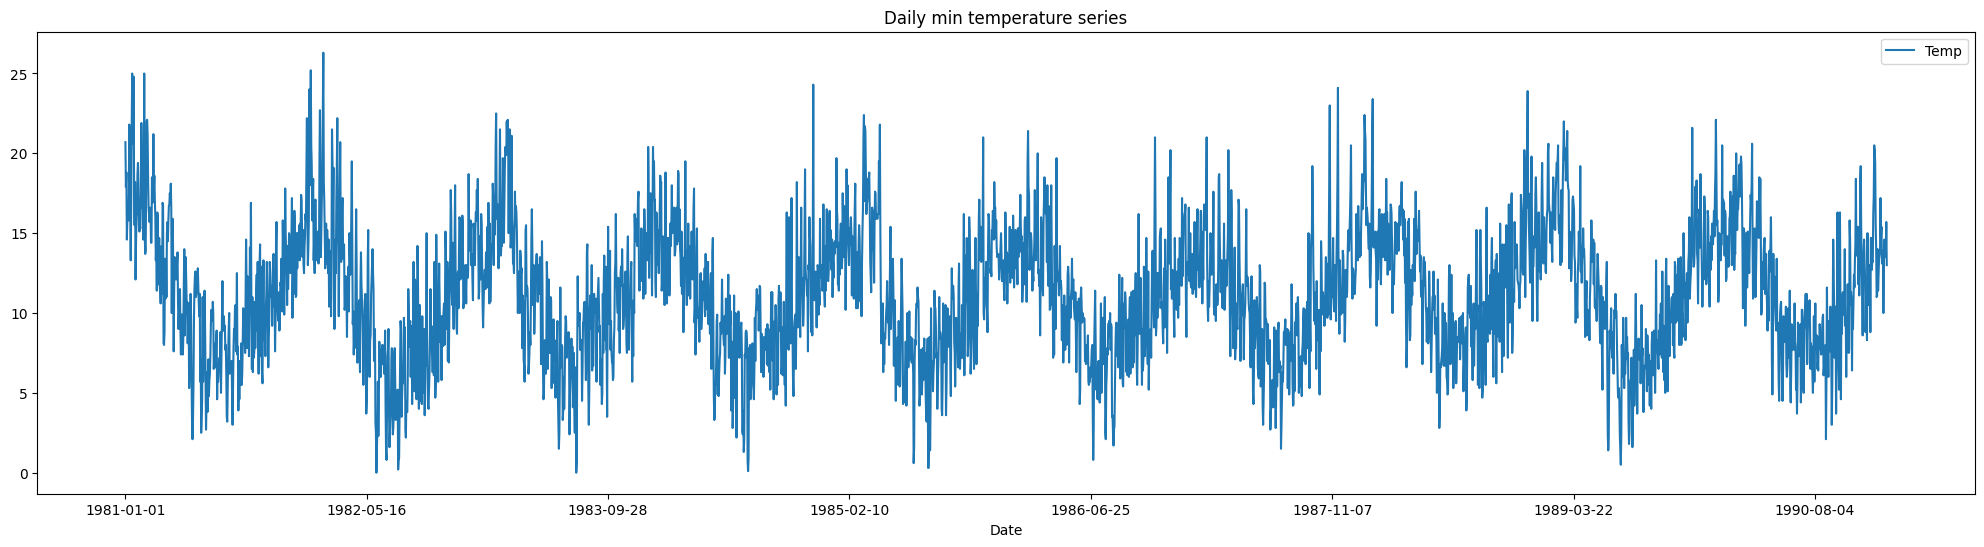

In [ ]:
#@title **code:** load and visualize the data
data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
ax = data_tem.plot(x='Date',title='Daily min temperature series', figsize=(25, 6));
#@title Plot train, validation and test series { display-mode: "form" }data_tem.head()

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Implement a function that split serie in training, validation and test, according to some input sizes.

- Split both: series `series_split` and corresponding time `time_split`
- Return  a list with the three respective sub-lists

In [ ]:
#@title **code student** split series
def split_series(time, serie, train_rate=0.5, test_rate=0.25, validation_rate=0.25):
    n = len(serie)
    series_split = [serie[:int(n*train_rate)],
                    serie[int(n*train_rate):int(n*train_rate)+int(n*validation_rate)],
                    serie[-int(n*test_rate):]]
    time_split = [time[:int(n*train_rate)],
                    time[int(n*train_rate):int(n*train_rate)+int(n*validation_rate)],
                    time[-int(n*test_rate):]]
    return time_split, series_split

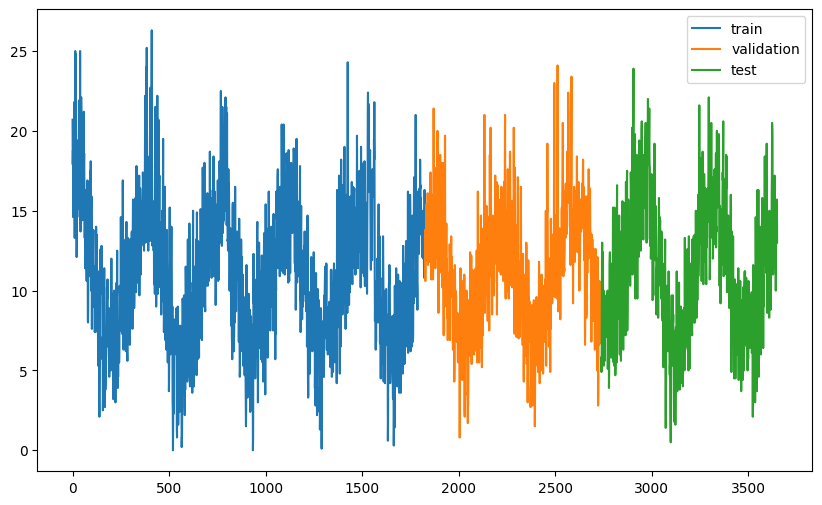

In [ ]:
#@title **code** plot the resultant splits

data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
series = data_tem.Temp.values
time = data_tem.index.values


time_sets, series_sets = split_series(time, series)
fig = plt.figure(figsize=(10, 6))
plt.plot(time_sets[0], series_sets[0], label='train')
plt.plot(time_sets[1], series_sets[1], label='validation')
plt.plot(time_sets[2], series_sets[2], label='test')
plt.legend()
plt.show()

#**2. Forecasting from RNN models**
 Same forecasting problem can be solved with deep neural networks with main advantage to learn weigths of history serie and also to be adaptable to very non linear changes, commonly in time series of real scenarios.

Firstly we need to arrange dataset for training net, in sense that works as illustrated in next figure:

### **2.1 Built the dataset for Tensorflow and RNN**
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/sliding_dataset.gif" style="width:700;height:350px;">

Tensorflow help with this construction using `from_tensor_slices`. For instance for a serie:

```
[0, 1, 2, 3, 4, 5, 6, 7]
```

Firstly split data and  create the windows shifted 1 position (
`dataset.window()`):

```
[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
```
Then, choose for $t-w$ features for $t$ value:

```
[0, 1, 2, 3][4]
[1, 2, 3, 4][5]
[2, 3, 4, 5][6]
```
 Then shuffle data. See the function as follows:







In [ ]:
#@title **code** building the dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position,
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
#@title **code** create the dataset for RNN

window_size = 30 # number of features in a window
batch_size = 128 # number of samples
shuffle_buffer_size = 1000 # shuffle the first 1000 samples
per_test = 0.3 # percentage of data to test

# Split series into train, validation and test
# load data
data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
serie = data_tem.Temp.values
len_n = len(serie)
time = data_tem.index.values
time_sets, series_sets = split_series(time=time, serie=serie, train_rate=0.7, validation_rate=0.20, test_rate=0.10)

dataset = windowed_dataset(series_sets[0], window_size=window_size, batch_size=32, shuffle_buffer=100)

We can visualize the dataset arrangement as follows:

In [ ]:
#@title **code** visualize one example in dataset
for i, (x,y) in enumerate(dataset):
  if i == 1:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (temperature days): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

Number of samples in each batch:  32
Number of labels in each batch:  32
Number of features of each sample (temperature days):  30
---------------------
X_1 = 
 [21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5 21.2 17.8
 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8 11.3 10.6
 11.7 14.2]


Y_1 =  11.2


### **4.2 Built the RNN**

In [ ]:
#@title **code** Building  the RNN model

# Define the layers ########################################################
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model = tf.keras.Model(inputs=input_, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 InputTransform (Lambda)     (None, 30, 1)             0         
                                                                 
 RNN_layer1 (SimpleRNN)      (None, 30, 20)            440       
                                                                 
 RNN_layer2 (SimpleRNN)      (None, 20)                820       
                                                                 
 ouput_layer (Dense)         (None, 1)                 21        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- How is the resultant RNN architecture from previous model?


In [ ]:
#@title **code** Now we proceed to train the model

# Clear the previous sessions and set the seed
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9))
# fit
history = model.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
79/79 [==============================] - 11s 53ms/step - loss: 39.7601 - mse: 39.7601 - mae: 4.7689
Epoch 2/20
79/79 [==============================] - 5s 67ms/step - loss: 11.5510 - mse: 11.5510 - mae: 2.6222
Epoch 3/20
79/79 [==============================] - 4s 51ms/step - loss: 8.8378 - mse: 8.8378 - mae: 2.2929
Epoch 4/20
79/79 [==============================] - 6s 76ms/step - loss: 8.1306 - mse: 8.1306 - mae: 2.2074
Epoch 5/20
79/79 [==============================] - 4s 51ms/step - loss: 7.6814 - mse: 7.6814 - mae: 2.1435
Epoch 6/20
79/79 [==============================] - 6s 72ms/step - loss: 7.3657 - mse: 7.3657 - mae: 2.0964
Epoch 7/20
79/79 [==============================] - 5s 69ms/step - loss: 7.2587 - mse: 7.2587 - mae: 2.0878
Epoch 8/20
79/79 [==============================] - 5s 61ms/step - loss: 6.9862 - mse: 6.9862 - mae: 2.0535
Epoch 9/20
79/79 [==============================] - 4s 52ms/step - loss: 6.8322 - mse: 6.8322 - mae: 2.0268
Epoch 10/20
79/79 [====

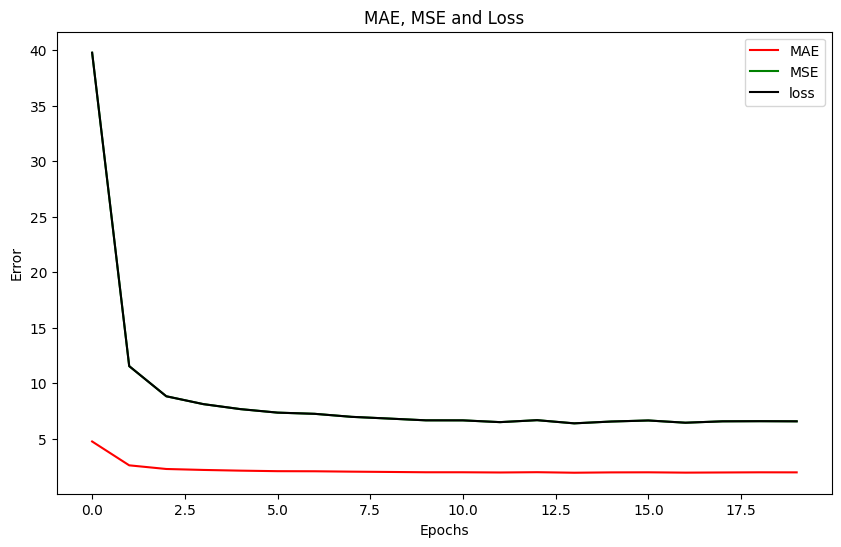

In [ ]:
#@title **code** Plot performance on training
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']


epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

**Finally, we can forecasting with RNN model**

In [ ]:
#@title **code**  we can run same walk forward over time steps in validation and test

validation_init = int(len_n*0.7)
test_init = int(len_n*0.9)

forecast_validation = []
forecast_test = []
for t in range(len_n-1):
    if t >= validation_init and t < test_init:
        # Don't forget to add the extra axis to predict
        forecast_validation.append(model.predict(serie[t-window_size:t][np.newaxis]))
    elif t >= test_init:
        forecast_test.append(model.predict(serie[t-window_size:t][np.newaxis]))

# delete 1 dimensions to plot results
forecast_validation = np.squeeze(np.array(forecast_validation))
forecast_test = np.squeeze(np.array(forecast_test))

1/1 [==============================] - 0s 43ms/step


In [ ]:
#@title **code**: plot_series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

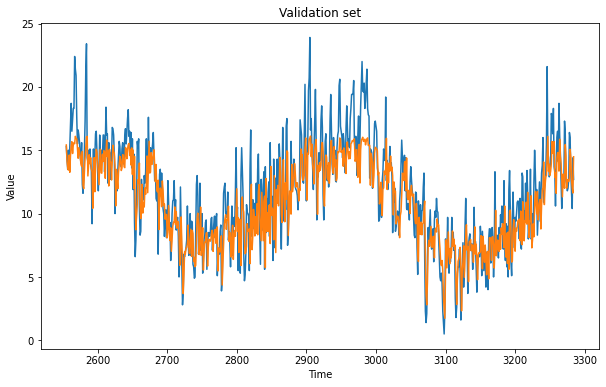

MSE in validation set 5.9280334
MAE in validation set 1.9233449


In [ ]:
#@title plot forecast in validation { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Validation set')
plot_series(time_sets[1], series_sets[1])
plot_series(time_sets[1], forecast_validation)
plt.show()
print('MSE in validation set', tf.keras.metrics.mean_squared_error(series_sets[1], forecast_validation).numpy())
print('MAE in validation set', tf.keras.metrics.mean_absolute_error(series_sets[1], forecast_validation).numpy())

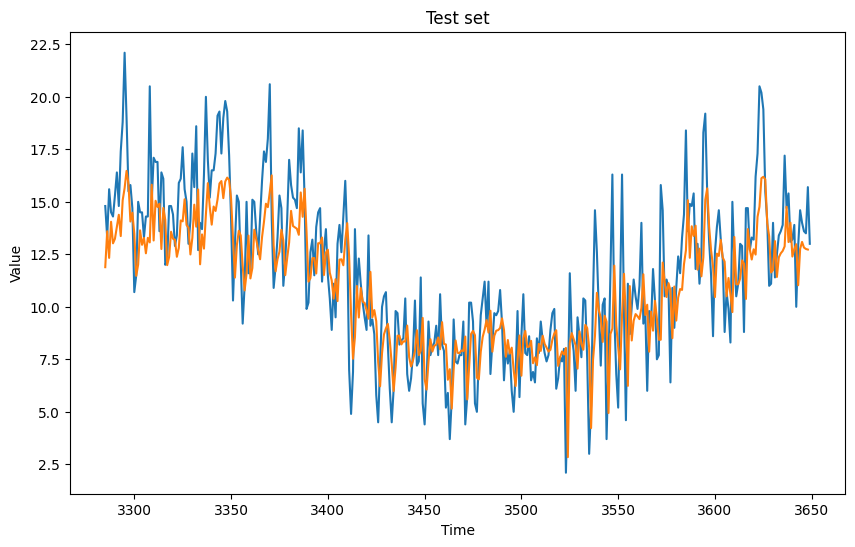

MSE in test set 5.729087
MAE in test set 1.8803538


In [ ]:
#@title plot forecast in test { display-mode: "form" }
plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()

print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

- Change optimizer retrain and plot
- Put a dense layer before dense linear output with relu activation. Evalaute the model.
- Until now you have explored only trainin set prediction. Now built a test dataset, predict and plot w.r.t the original plot. Uses as training 70% and test 30% of original serie


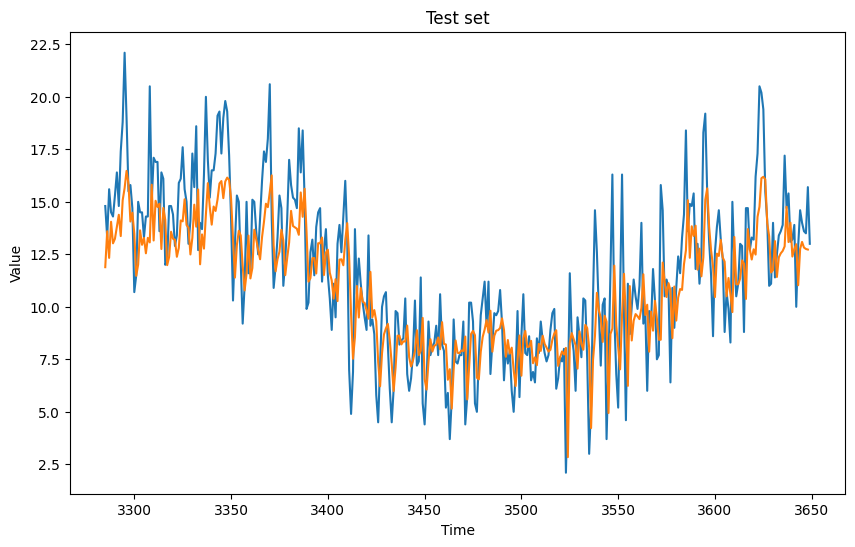

MSE in test set 5.729087
MAE in test set 1.8803538


In [ ]:
#@title **code student** Change optimizer retrain and plot
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)



plt.figure(figsize=(10, 6))
plt.title('Test set')
plot_series(time_sets[2], series_sets[2])
plot_series(time_sets[2][:-1], forecast_test)
plt.show()

print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


In [ ]:
#@title **code student** Put a dense layer before dense linear output. Evalaute the model.




model2 = tf.keras.Model(inputs=input_, outputs=y)
model2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 InputTransform (Lambda)     (None, 30, 1)             0         
                                                                 
 RNN_layer1 (SimpleRNN)      (None, 30, 20)            440       
                                                                 
 RNN_layer2 (SimpleRNN)      (None, 20)                820       
                                                                 
 ouput_layer (Dense)         (None, 1)                 21        
                                                                 
Total params: 1281 (5.00 KB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#@title **code student**
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)





print('MSE in test set', tf.keras.metrics.mean_squared_error(series_sets[2][:-1], forecast_test).numpy())
print('MAE in test set', tf.keras.metrics.mean_absolute_error(series_sets[2][:-1], forecast_test).numpy())


MSE in test set 5.729087
MAE in test set 1.8803538


In [ ]:
#@title **code** split_series
def split_series(time, serie, train_rate=0.5, test_rate=0.25, validation_rate=0.25):
    num_examples = len(serie)
    # split series in train, validation and test sets
    series_split = [serie[:int(num_examples*train_rate)],
                    serie[int(num_examples*train_rate):int(num_examples*train_rate)+int(num_examples*validation_rate)],
                    serie[-int(num_examples*test_rate):]]
    # split time for train, validation and test series
    time_split = [time[:int(num_examples*train_rate)],
                  time[int(num_examples*train_rate):int(num_examples*train_rate)+int(num_examples*validation_rate)],
                  time[-int(num_examples*test_rate):]]

    return time_split, series_split

In [ ]:
#@title **code profesor** Split dataset in train and test. Then plot estimations.

window_size = 30 # number of features in a window
batch_size = 128 # number of samples
shuffle_buffer_size = 1000 # shuffle the first 1000 samples
per_test = 0.3 # percentage of data to test

# Split series into train, validation and test
# load data
data_tem = pd.read_csv("data/dailyMin_temperatures.csv")
serie = data_tem.Temp.values
len_n = len(serie)
print("lent serie: ", len_n)
time = data_tem.index.values
time_sets, series_sets = split_series(time=time, serie=serie, train_rate=0.7, validation_rate=0.0, test_rate=0.30)
print(len(series_sets), "train: ", len(series_sets[0]), " test: ", len(series_sets[2]))

lent serie:  3650
3 train:  2555  test:  1095


In [ ]:
#@title **code student** create a dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):




    return dataset

(1065, 1)


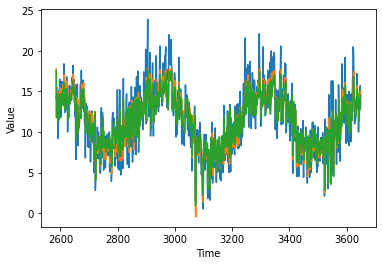

In [ ]:
#@title **code student** evaluate performance on test




print(testPredict_1.shape)
plot_series(time_sets[2][window_size:], series_sets[2][window_size:])
plot_series(time_sets[2][window_size:], testPredict_1)
plot_series(time_sets[2][window_size:], testPredict_2)


# **3. Forecasting to predict stock market index**

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Forecasting of IBM stock market index. Please load the dataset in data :

```
datasets_8388_11883_IBM_2006-01-01_to_2018-01-01
```
 - Use only one serie (High, for instance) to train and configurate RNN.
 - Use for training 70% and the rest for test

In [ ]:
#@title **code** Load data of IBM
data_IBM = pd.read_csv("data/datasets_8388_11883_IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data_IBM.shape)
data_IBM.head(5)

(3020, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


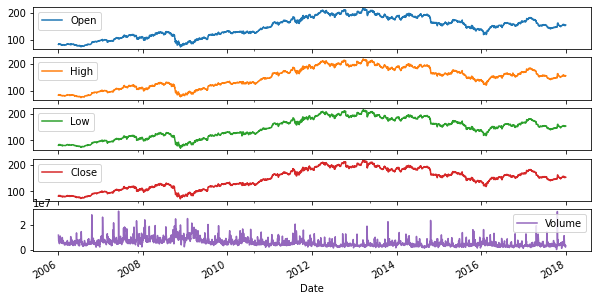

In [ ]:
#@title **code** plot data
data_IBM.plot(subplots=True, figsize=(10,5));

In [ ]:
#@title **code student** select for training all dataes until 2016
#@markdown we only we should to consider **HIGH**

#@markdown for test use 2017 data




print(set_entrenamiento.shape, set_test.shape)

set_entrenamiento.head(3)

(2769, 1) (251, 1)


,High
Date,
2006-01-03,82.55
2006-01-04,82.50
2006-01-05,82.90


In [ ]:
#@title **code student** we typically should normalize data to obtain a better performance
#@markdown Use MaxMinscaler to scale trainin set betwwen [0-1]
#@markdown Use also standardscaler

#@markdown Reshape to (data,)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



In [ ]:
#@title **code** code (set_entrenamiento_escalado)
#@markdown into a dataset
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position,
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # choose t --> t-1 as a features and the last one as a label
    # [0, 1, 2, 3][4]
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    if (shuffle_buffer is not 0):
      print("shuffle")
      dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    # x = [[0, 1, 2, 3], [4, 5, 6, 7]]
    # y = [[4], [8]]
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size=50
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=32, shuffle_buffer=100)

shuffle


In [ ]:
#@title **test** evaluate dataset
for i, (x,y) in enumerate(train_data):
  if i == 0:
    print('Number of samples in each batch: ', x.numpy().shape[0])
    print('Number of labels in each batch: ', y.numpy().shape[0])
    print('Number of features of each sample (IBM index): ', x.numpy().shape[1])
    print('---------------------')
    print('X_1 = \n', x.numpy()[1])
    print('\n')
    print('Y_1 = ', y.numpy()[1])

Number of samples in each batch:  32
Number of labels in each batch:  32
Number of features of each sample (temperature days):  50
---------------------
X_1 = 
 [-1.57628637 -1.57962602 -1.56190016 -1.58373637 -1.59683809 -1.60428809
 -1.56472602 -1.57268982 -1.60711396 -1.63614327 -1.63023465 -1.64385016
 -1.64307947 -1.63999672 -1.63896913 -1.63408809 -1.62792258 -1.64462085
 -1.66568637 -1.68675189 -1.68058637 -1.66234672 -1.66491568 -1.64796051
 -1.63640016 -1.64821741 -1.64693292 -1.66208982 -1.65900706 -1.66620016
 -1.64307947 -1.65104327 -1.66876913 -1.66260361 -1.6713381  -1.66465878
 -1.68007258 -1.66414499 -1.66902603 -1.66517258 -1.64436396 -1.63460189
 -1.62766568 -1.62381223 -1.60865534 -1.5888743  -1.58990189 -1.59786568
 -1.5891312  -1.55727602]


Y_1 =  -1.5652398178507239


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ########################################################
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model_3 = tf.keras.Model(inputs=input_, outputs=y)
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
InputTransform (Lambda)      (None, 50, 1)             0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 50, 20)            440       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
85/85 [==============================] - 7s 66ms/step - loss: 1.1886 - mse: 1.1886 - mae: 0.6709
Epoch 2/5
85/85 [==============================] - 6s 66ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1037
Epoch 3/5
85/85 [==============================] - 6s 66ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0754
Epoch 4/5
85/85 [==============================] - 6s 65ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0686
Epoch 5/5
85/85 [==============================] - 6s 66ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0629


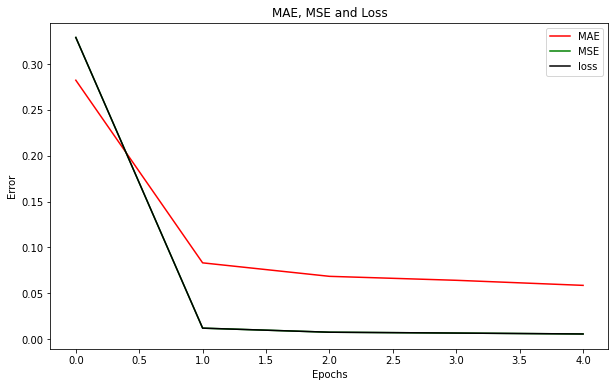

In [ ]:
#@title **code student** define model parameters
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)




epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(2719, 1) (201, 1)
(2719, 1)


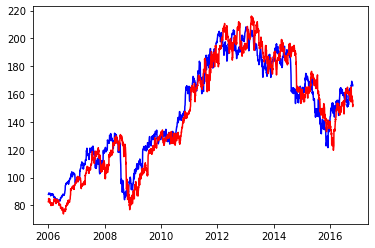

In [ ]:
#@title **code student** evaluate for training and test





train_pred = sc.inverse_transform(train_IBM)

time = data_IBM.index.values
print(train_pred.shape)
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], train_pred[:,0],color='blue', label='predicted')
plt.plot(set_entrenamiento.index.values[0:train_pred.shape[0]], set_entrenamiento.High.values[0:train_pred.shape[0]], color='red', label='real')

(201, 1) (251, 1)


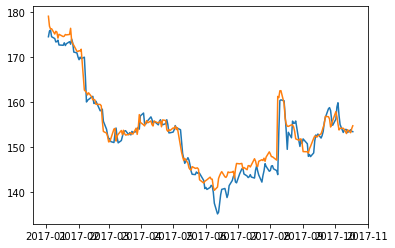

In [ ]:
#@title **code student** plot the test



plt.plot(set_test.index.values[0:test_IBM.shape[0]], pred_test)
plt.plot(set_test.index.values[0:test_IBM.shape[0]], set_test[50:])

(201, 1) (251,)


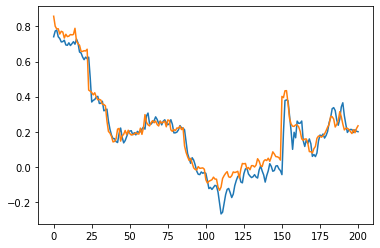

In [ ]:
#@title **code student** plot the test (raw predictions)




### **Some conclusions**
- RNN are sufficient to follow and forecasting temporal series with marked patterns

- In more complex dataset looks no sufficient to forecast series (short memory)

### **4.2 Built a multivariate RNN architecture**

Much of the problems can be described by multiple variables and we can take advantage of these additional features to better represent our problem.  In tensorflow the input configuration follow next tensor structure.

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/dim_rnn.png" width="450" height="380">



In [ ]:
#@title **code** load the dataset
data_IBM = pd.read_csv("data/datasets_8388_11883_IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data_IBM.shape)
data_IBM.head(5)

(3020, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
#@markdown **code** Load multivariate dataset
set_entrenamiento = data_IBM[:'2016'].iloc[:,1:5]
set_test = data_IBM['2017':].iloc[:,1:5]
set_entrenamiento.head(3)

,High,Low,Close,Volume
Date,,,,
2006-01-03,82.55,80.81,82.06,11715200
2006-01-04,82.50,81.33,81.95,9840600
2006-01-05,82.90,81.00,82.50,7213500


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/icon1.png" width="200">

Now, you should implement a RNN multivariate using the four values.

- Implement the dataset for this configuration
- Define and architecture that receive the n_features:

```
input_ = tf.keras.layers.Input((window_size, features))
```
- Evaluate the model with and without scale factor.
- Review Taller 3



# References

[1. Forecasting: principles and practique](https://otexts.com/fpp2/)

[2. Sequences, Time Series and Prediction](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/)

[3. RNN in tensorflow](https://www.tensorflow.org/guide/keras/rnn)



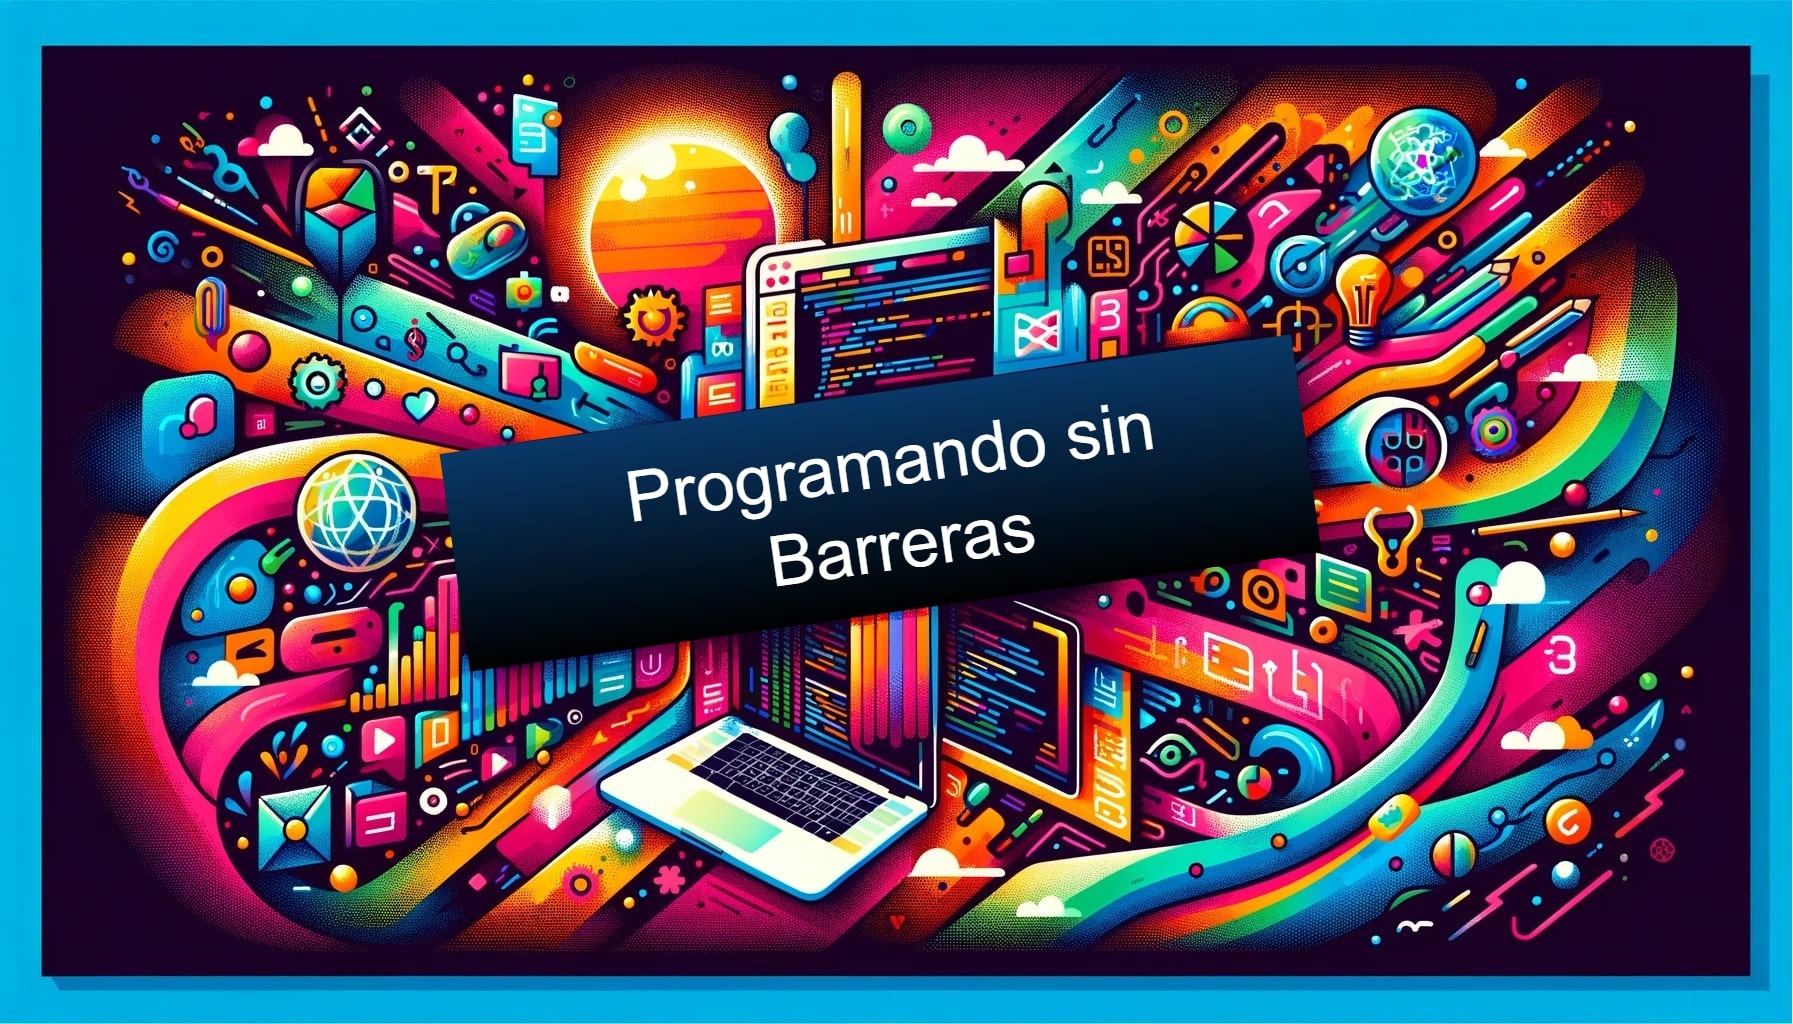